In [125]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import re

In [126]:
file_path = "Life Expectancy Data.csv"
df_life_exp = pd.read_csv(file_path)

In [127]:
df_life_exp.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [128]:
df_life_exp.info()
df_life_exp.head()
df_life_exp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


The column names are all wrong. Let's fix that.

In [129]:
new_col_names = {}
for col_name in df_life_exp.columns:
    # Strip the name from extra white space and switch to lower case
    new_col_names[col_name] = re.sub(' +', ' ',col_name.strip().lower())
    # Display the change in name
    print("'"+col_name+"'", '->', "'"+new_col_names[col_name]+"'")
# Rename the columns into a new data frame
df_life_exp_renamed = df_life_exp.rename(columns=new_col_names)

'Country' -> 'country'
'Year' -> 'year'
'Status' -> 'status'
'Life expectancy ' -> 'life expectancy'
'Adult Mortality' -> 'adult mortality'
'infant deaths' -> 'infant deaths'
'Alcohol' -> 'alcohol'
'percentage expenditure' -> 'percentage expenditure'
'Hepatitis B' -> 'hepatitis b'
'Measles ' -> 'measles'
' BMI ' -> 'bmi'
'under-five deaths ' -> 'under-five deaths'
'Polio' -> 'polio'
'Total expenditure' -> 'total expenditure'
'Diphtheria ' -> 'diphtheria'
' HIV/AIDS' -> 'hiv/aids'
'GDP' -> 'gdp'
'Population' -> 'population'
' thinness  1-19 years' -> 'thinness 1-19 years'
' thinness 5-9 years' -> 'thinness 5-9 years'
'Income composition of resources' -> 'income composition of resources'
'Schooling' -> 'schooling'


Infant deaths and under-five deaths look similar. Let's check that

In [130]:
df_diff = df_life_exp_renamed['under-five deaths'] - df_life_exp_renamed['infant deaths']
df_diff = df_diff[df_diff != 0]
df_diff.max(), df_diff.min(), np.abs(df_diff).sum(), len(df_diff)

(700, 1, 34468, 1627)

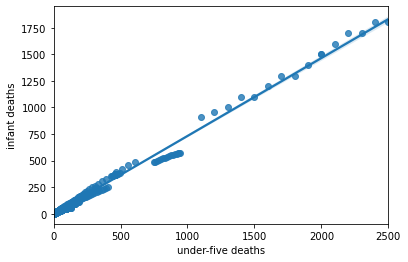

In [131]:
sns.regplot(x=df_life_exp_renamed['under-five deaths'], y=df_life_exp_renamed['infant deaths'])

Since there is a very high correlation and infant deaths is included in under-five deaths, so we drop infant deaths as it doesn't add new information.

In [132]:
df_life_exp_renamed.drop('infant deaths', axis=1, inplace=True)
df_life_exp_renamed.describe()

,year,life expectancy,adult mortality,alcohol,percentage expenditure,hepatitis b,measles,bmi,under-five deaths,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
count,2938.000000,2928.000000,2928.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


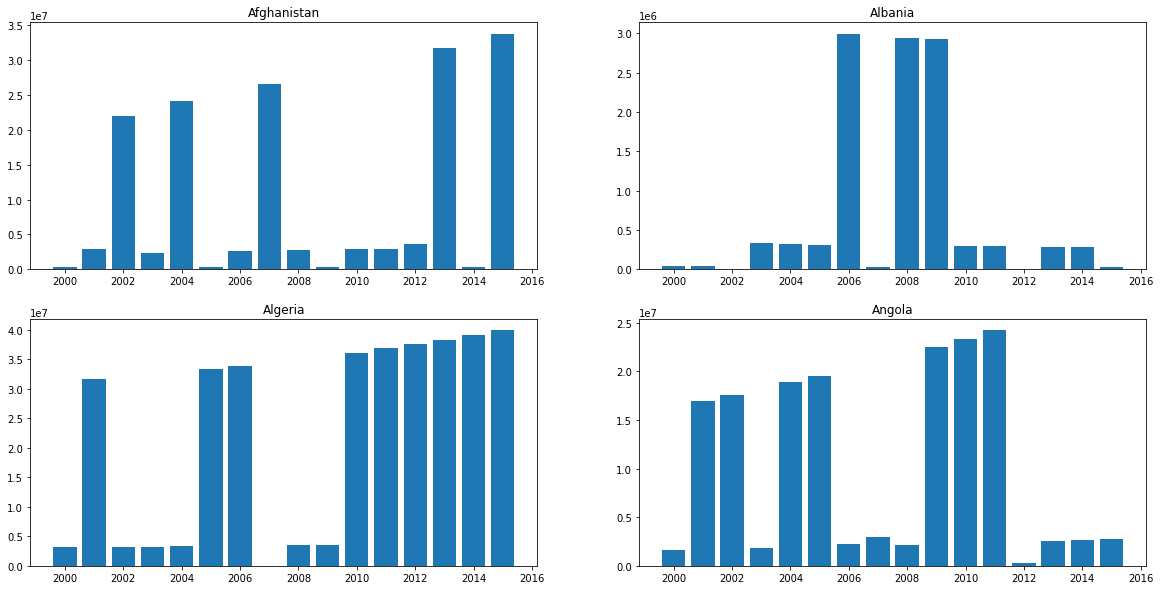

In [133]:
populationInfo = df_life_exp_renamed.groupby('country')['population']
numberOfCountries = 0
fig,a =  plt.subplots(2,2,figsize=(20,10))
for country in df_life_exp_renamed['country'].unique():
  data = df_life_exp_renamed[df_life_exp_renamed['country']==country]
  a[numberOfCountries//2][numberOfCountries%2].set_title(country)
  a[numberOfCountries//2][numberOfCountries%2].bar(data['year'],data['population'])
  numberOfCountries+=1
  if numberOfCountries==4:
    break
plt.show()

Since there is a lot of noise in the data, we group the data by Country and average all the years then drop the year since it becomes irrelevent.

In [134]:
df_life_exp_averaged = df_life_exp_renamed.groupby('country').mean()
df_life_exp_averaged = df_life_exp_averaged.drop('year', axis=1)
df_life_exp_averaged

,life expectancy,adult mortality,alcohol,percentage expenditure,hepatitis b,measles,bmi,under-five deaths,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
country,,,,,,,,,,,,,,,,,,
Afghanistan,58.19375,269.0625,0.014375,34.960110,64.562500,2362.2500,15.51875,107.5625,48.3750,8.252500,52.3125,0.10000,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250
Albania,75.15625,45.0625,4.848750,193.259091,98.000000,53.3750,49.06875,0.9375,98.1250,5.945625,98.0625,0.10000,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750
Algeria,73.61875,108.1875,0.406667,236.185241,78.000000,1943.8750,48.74375,23.5000,91.7500,4.604000,91.8750,0.10000,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250
Angola,49.01875,328.5625,5.740667,102.100268,70.222222,3561.3125,18.01875,132.6250,46.1250,3.919333,47.6875,2.36875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375
Antigua and Barbuda,75.05625,127.5000,7.949333,1001.585226,98.266667,0.0000,38.42500,0.0000,96.9375,4.791333,98.3125,0.12500,9759.305728,NaN,3.42500,3.37500,0.488625,8.84375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),73.38750,163.0000,7.420000,0.000000,66.250000,165.0000,54.48750,10.7500,74.6875,4.998667,68.5000,0.10000,NaN,NaN,1.65000,1.56250,0.726812,12.78750
Viet Nam,74.77500,126.5625,3.087333,0.000000,87.538462,4232.9375,11.18750,36.5000,94.9375,5.977333,91.7500,0.14375,NaN,NaN,14.92500,15.62500,0.627063,11.51250
Yemen,63.86250,211.8125,0.047333,0.000000,55.687500,2761.1875,33.48750,51.6250,67.1250,5.005333,72.6250,0.10000,NaN,NaN,13.83125,13.75000,0.475500,8.50625


There are some missing data points, so we explore how much of the data is missing.

In [137]:
# Calculate percentage of missing data
percent_missing = df_life_exp_averaged.isna().sum() * 100 / len(df_life_exp_averaged)
data = zip(df_life_exp_averaged.columns, percent_missing, df_life_exp_averaged.dtypes)
# Create data frame with missing data numbers
df_missing = pd.DataFrame(data=data, columns=['column name', '% missing', 'dtype'])
# Check columns with missing data
df_missing = df_missing[df_missing['% missing'] > 0]
df_missing

,column name,% missing,dtype
0,life expectancy,5.181347,float64
1,adult mortality,5.181347,float64
2,alcohol,1.036269,float64
4,hepatitis b,4.663212,float64
6,bmi,2.072539,float64
9,total expenditure,1.036269,float64
12,gdp,15.544041,float64
13,population,24.870466,float64
14,thinness 1-19 years,2.072539,float64
15,thinness 5-9 years,2.072539,float64


Since there is a large portion of the population is missing we drop the column.

In [138]:
df_life_exp_averaged.drop('population',axis=1,inplace=True)

Knowing that there's lots of missing data, we need to impute the missing data as follows:
1. Check the distribution of the missing columns.
1. Impute the missing values with a function that's appropriate to the distribution.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

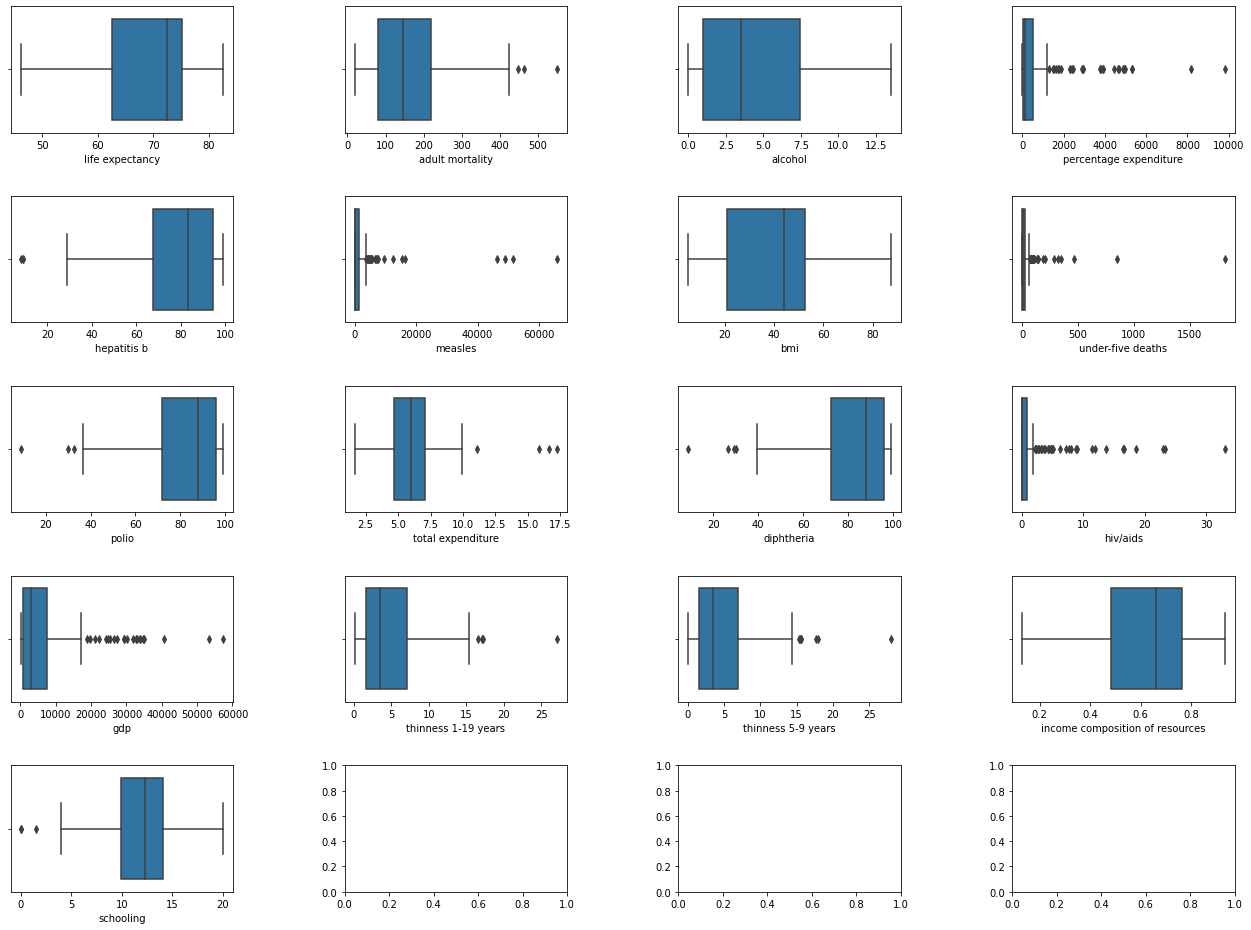

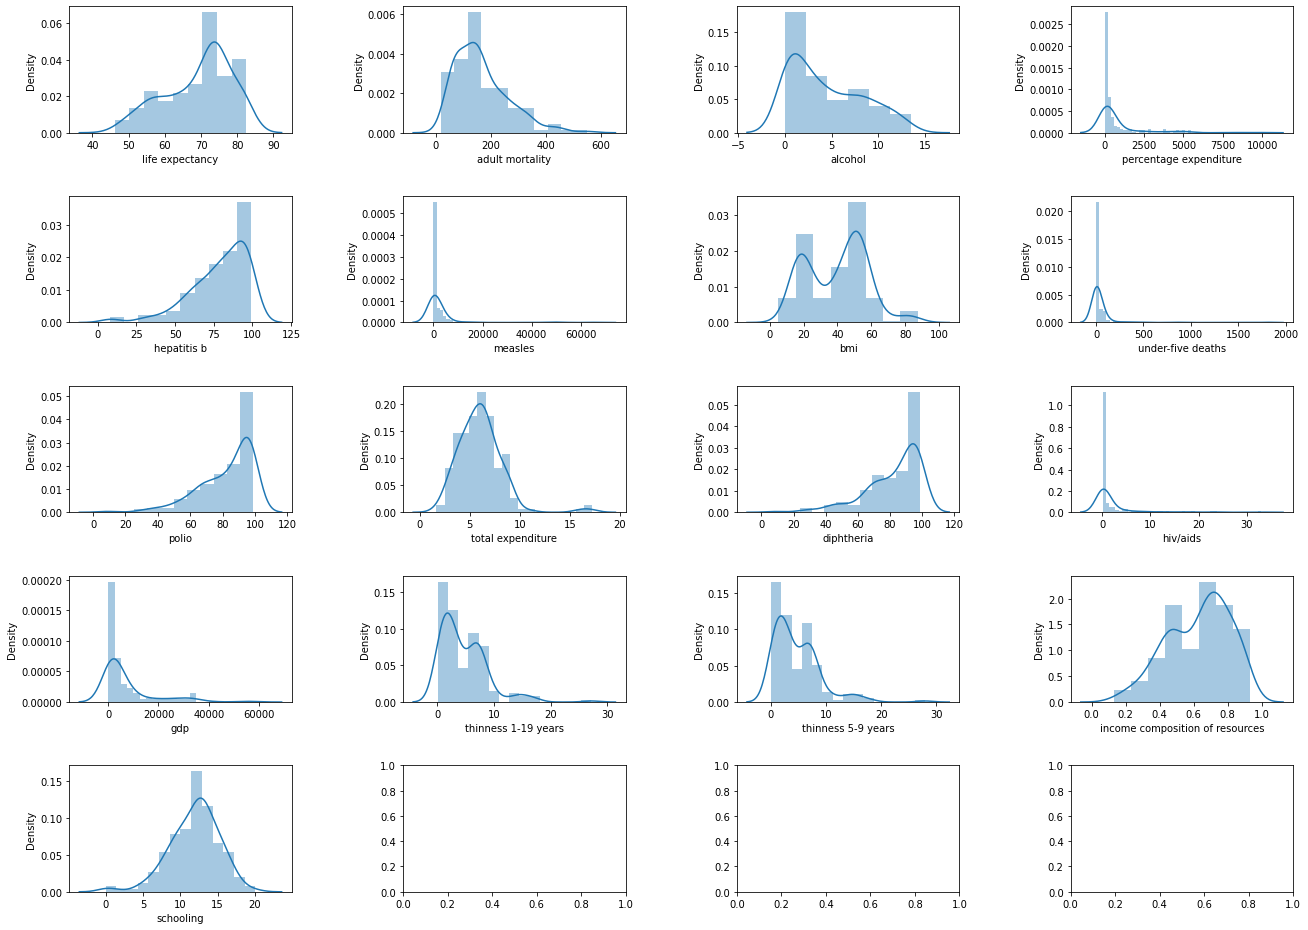

In [141]:
def plot(df, plotting_func, n_cols=4, n_rows=None, figsize=(20, 15)):
    assert (n_cols is None) ^ (n_rows is None), 'Define only one of n_rows or n_cols'
    # Get columns
    columns = df.columns
    # Derive the other dimension
    if n_rows != None:
        n_cols = math.ceil(len(columns) / n_rows)
    else:
        n_rows = math.ceil(len(columns) / n_cols)
    axes = plt.subplots(n_rows, n_cols, figsize=figsize)[1]
    for row in range(n_rows):    
        for col in range(n_cols):
            index = row * n_cols + col
            if index >= len(columns):
                break
            # Skip columns with non-numeric values
            if not pd.api.types.is_numeric_dtype(df[columns[index]]):
                continue
            plotting_func(df[columns[index]], ax=axes[row, col])
    plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.5, wspace=0.5)


# Check the distribution of the columns using box plots
plot(df_life_exp_averaged, sns.boxplot)
# Check the ditribution of the columns using dist plot (bar plots)
plot(df_life_exp_averaged, sns.distplot)

Since there are some outliers, we impute using the median.

In [146]:
df_life_exp_imputed = df_life_exp_averaged.copy()
df_life_exp_imputed.fillna((df_life_exp_imputed.median(axis=0)), inplace=True)

Now let's take a look at the correlation between columns

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1559: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1559: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1559: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume

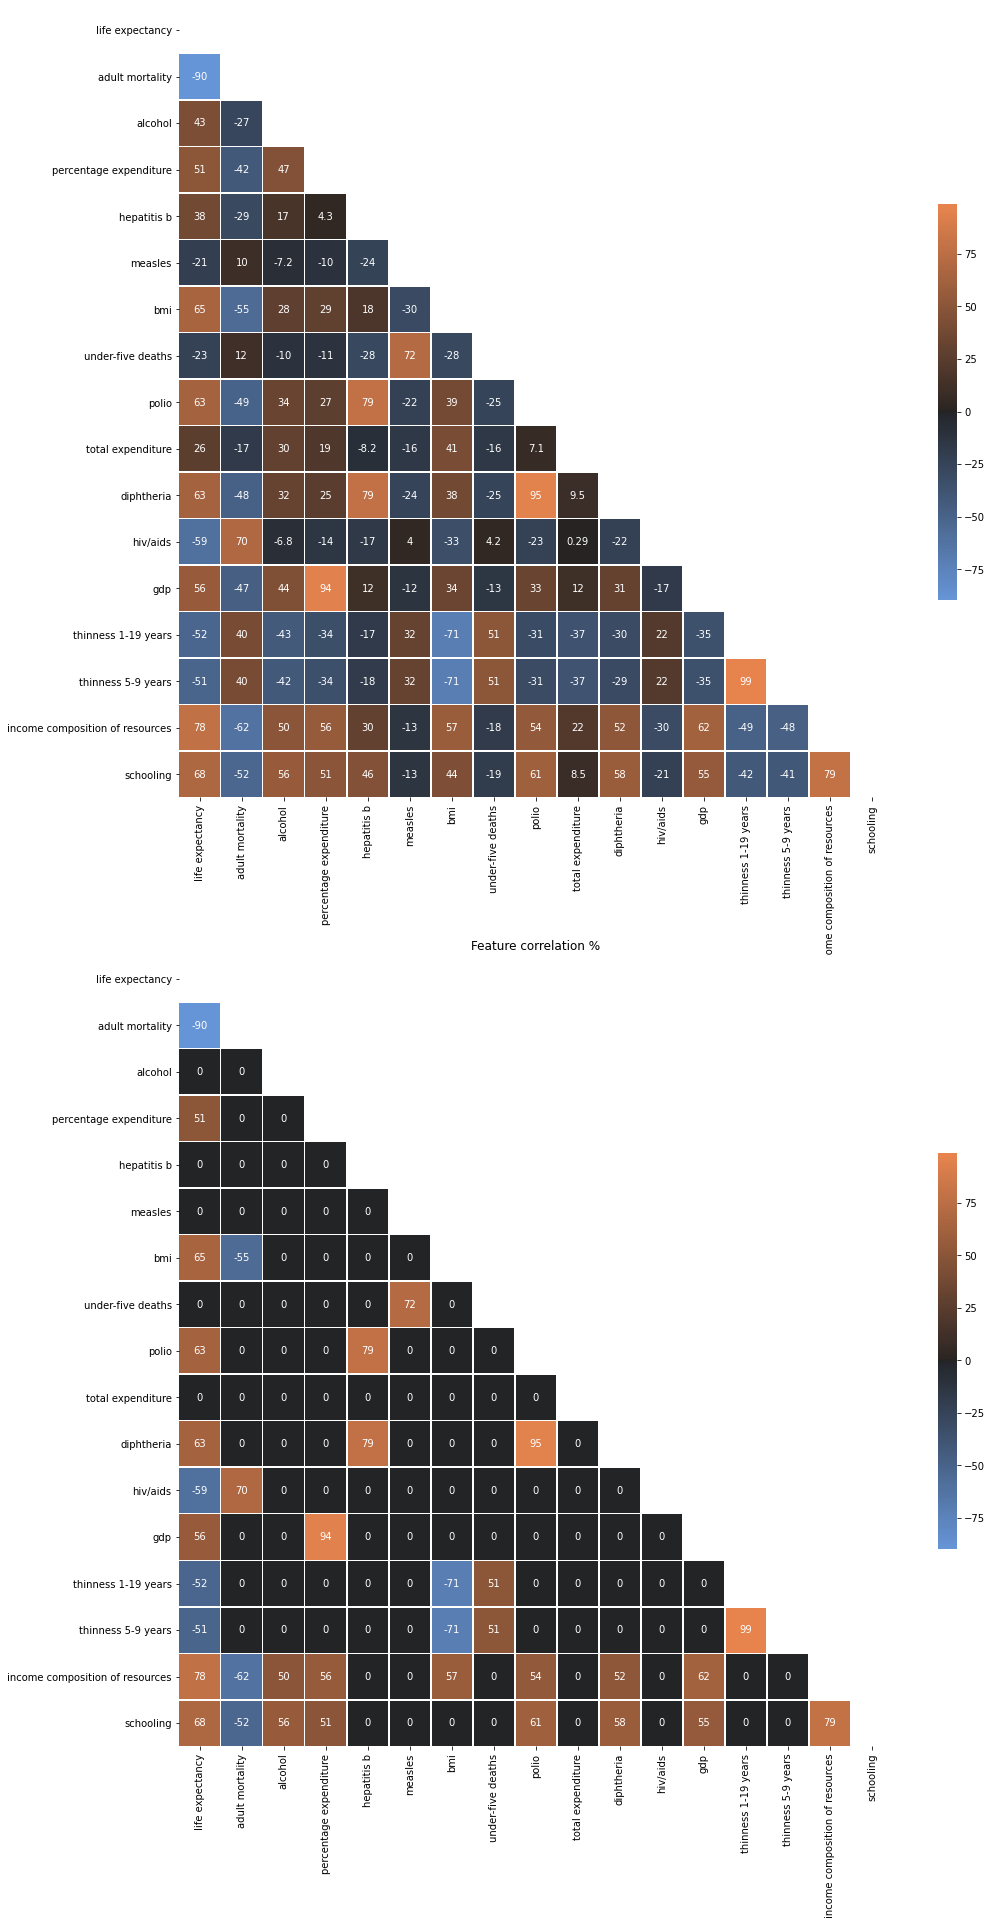

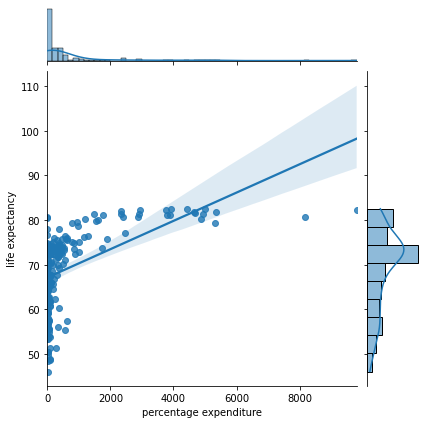

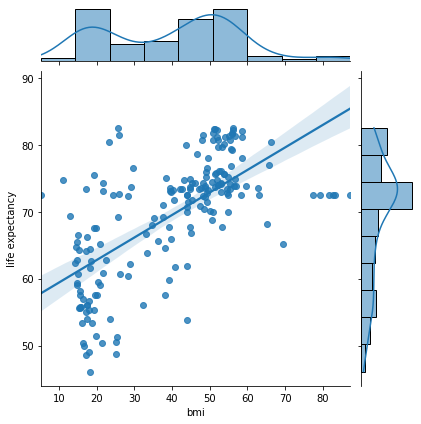

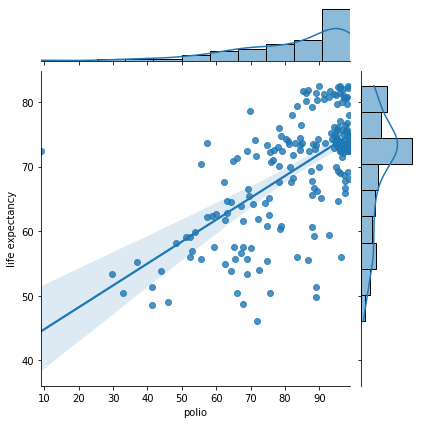

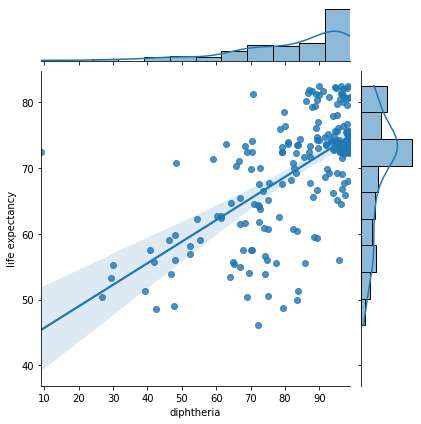

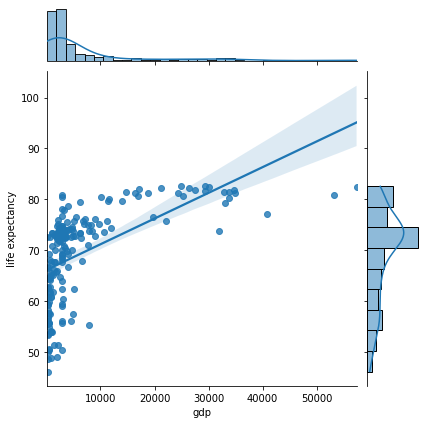

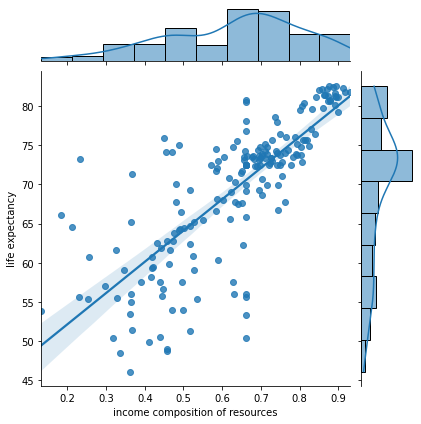

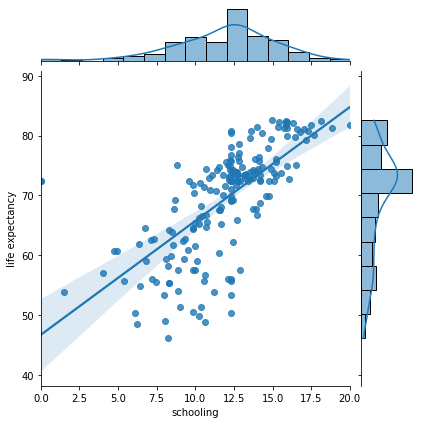

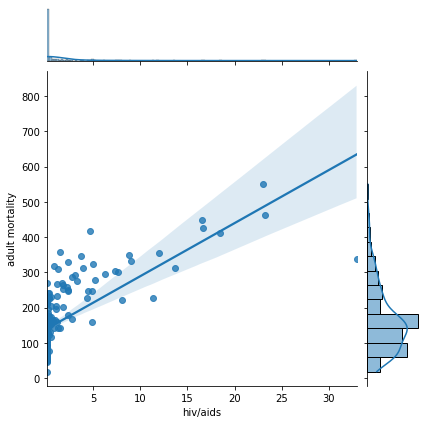

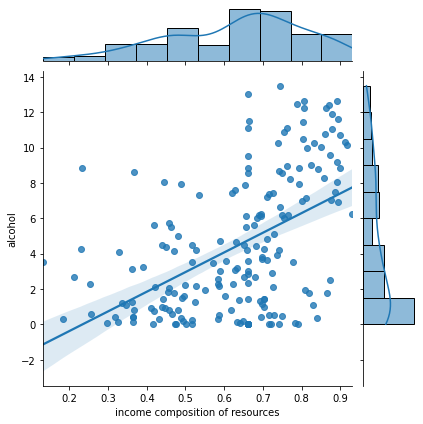

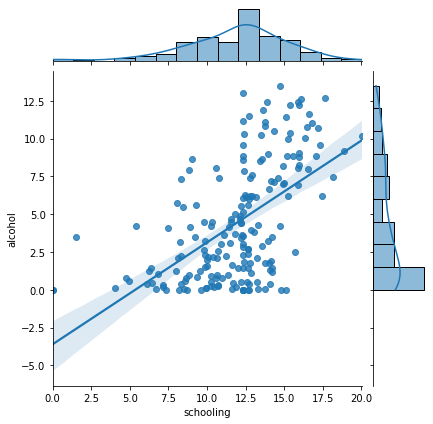

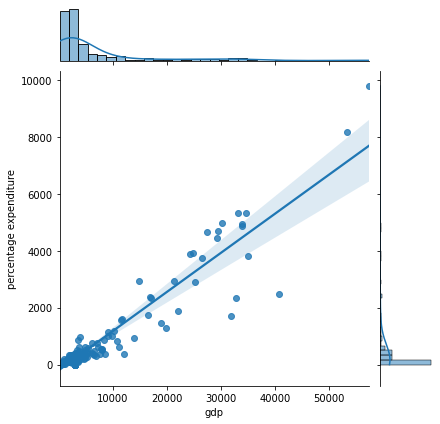

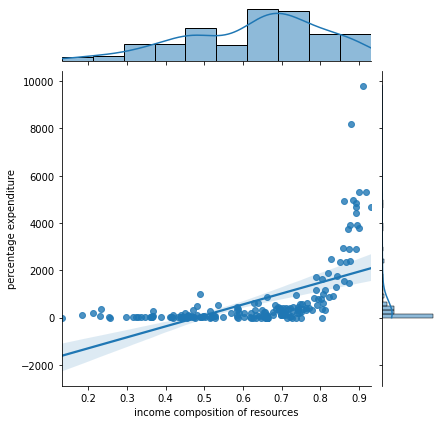

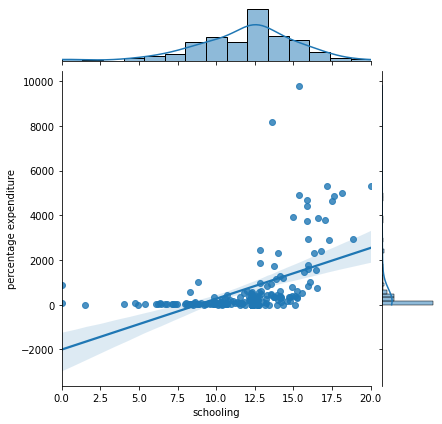

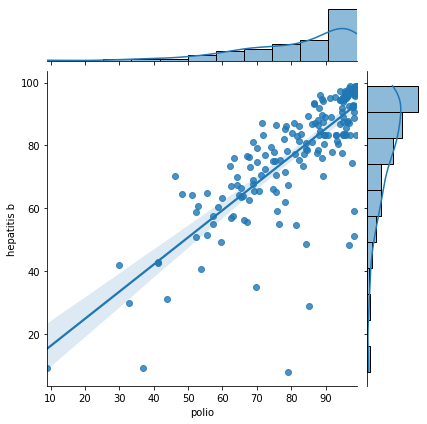

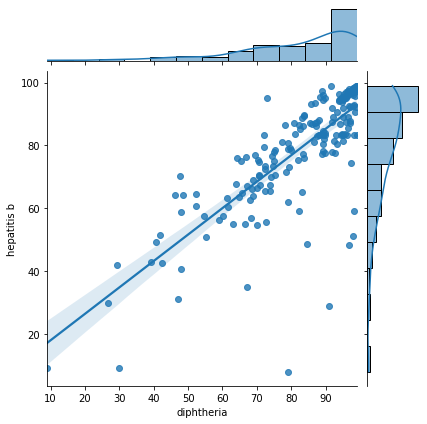

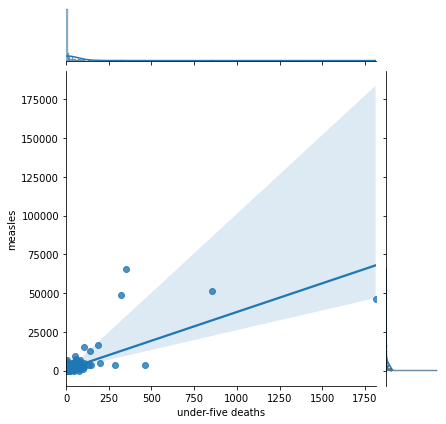

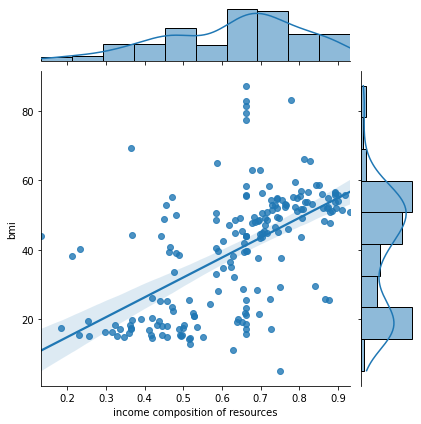

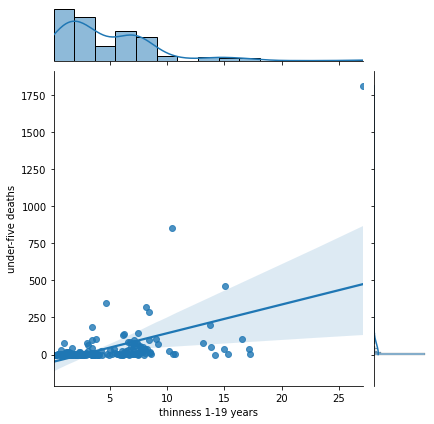

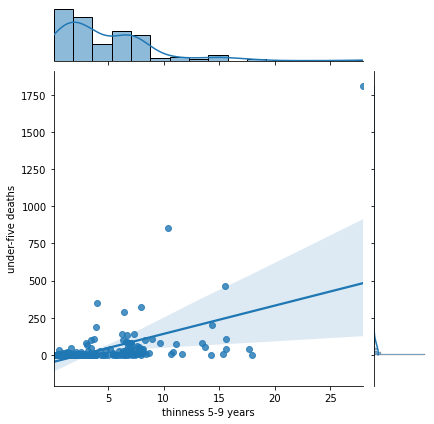

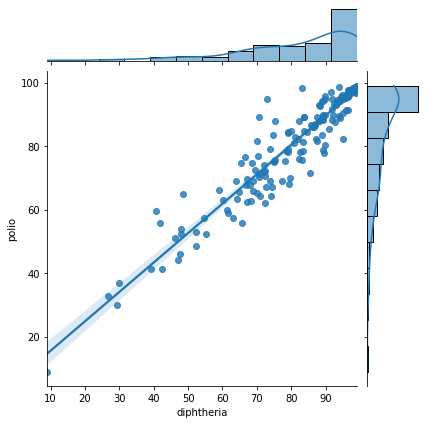

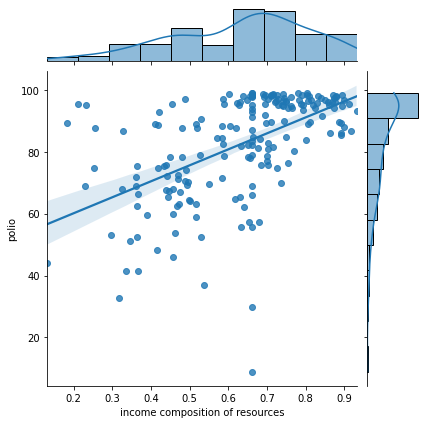

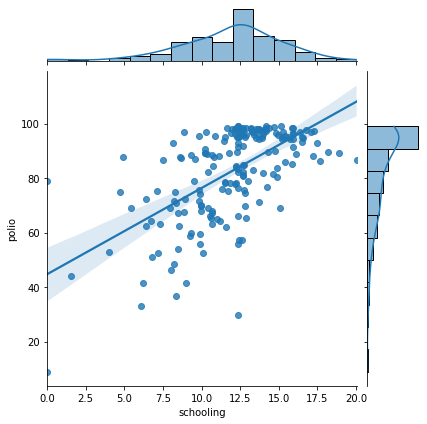

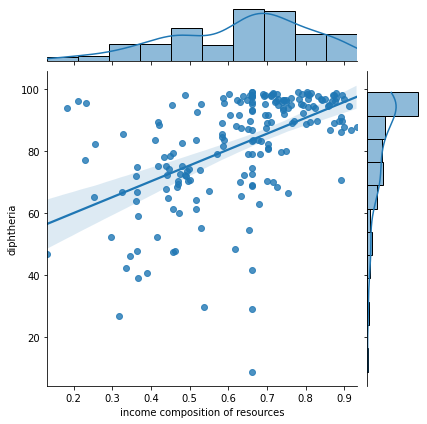

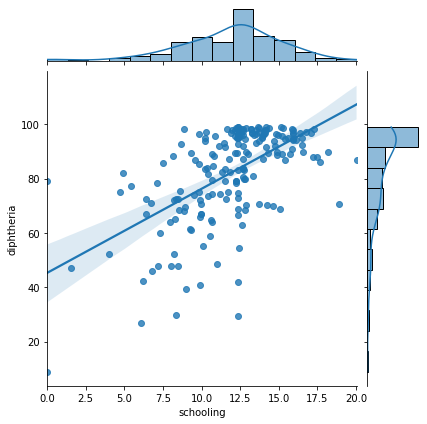

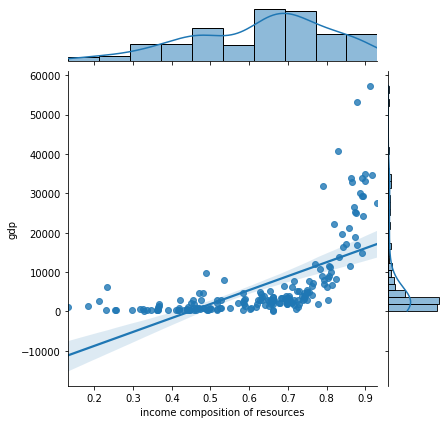

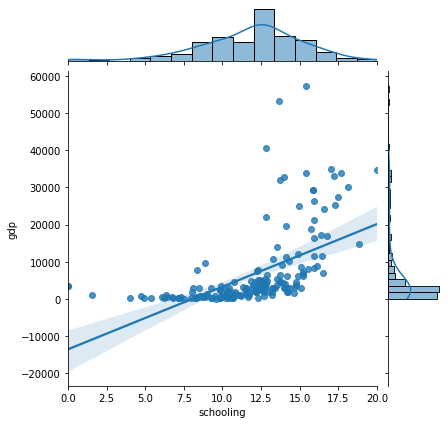

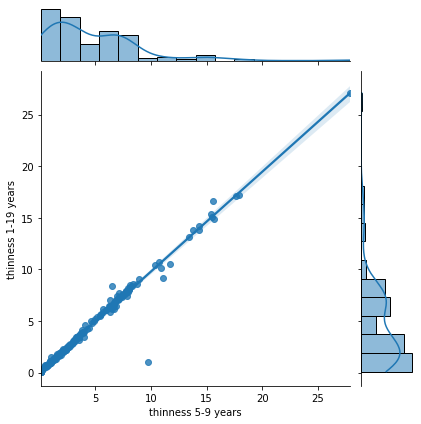

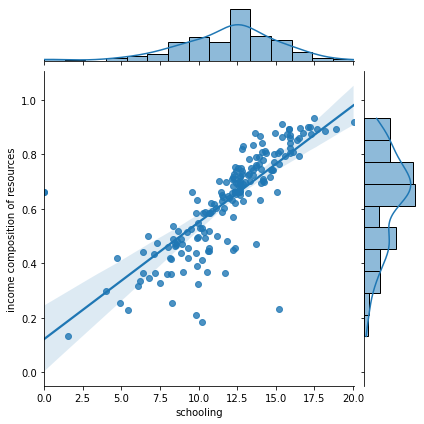

In [150]:
# Let's take a look at the correlation matrix
def plot_correlation_matrix(df, title=None, cutoff=50):
    # Computer correlation matrix
    corr_full = df.corr() * 100
    corr_cut = corr_full.copy()
    corr_cut[~((corr_cut <= -cutoff) | (corr_cut >= cutoff))] = 0
    axs = plt.subplots(2, 1, figsize=(16, 32))[1]
    for (corr, ax) in zip([corr_full, corr_cut], axs):
        # Generate mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))
        # Set up figure
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
        # Draw the heatmap with the mask and corrent aspect ratio
        sns.heatmap(corr, mask=mask, center=0.0, cmap=cmap, linewidths=.5, cbar_kws={'shrink':.5}, annot=True, ax=ax)
        if title:
            plt.title(title)
    corr_cut[mask] = 0
    # Return the cutoff mask
    return corr_cut


cutoff = 50
corr_cut = plot_correlation_matrix(df_life_exp_imputed, 'Feature correlation %', cutoff)
# Lets check the joint plots of correlated data above the cutoff
corr_cut = corr_cut[corr_cut > 0.0].reset_index()
corr_cut = corr_cut.melt(id_vars='index', value_name='corr', var_name='x2')
corr_cut = corr_cut[corr_cut['corr'].notna()]
for x1, x2, _ in corr_cut.values:
    sns.jointplot(x=x1, y=x2, data=df_life_exp_imputed, kind='reg')

In [151]:
df_life_exp_imputed.to_csv('lifeExpectancyGen.csv')